# **Проект для «Викишоп».**

**Описание проекта.**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

**Инструменты.**

pandas, numpy, matplotlib, sklearn, spacy.

## Загрузка и анализ данных.

In [1]:
!pip install transformers

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import torch
import transformers
from transformers import BertTokenizer
from tqdm import notebook
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import time
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score
)
import spacy
from spacy.lang.de.stop_words import STOP_WORDS
type(STOP_WORDS)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

STATE = 42

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [6]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


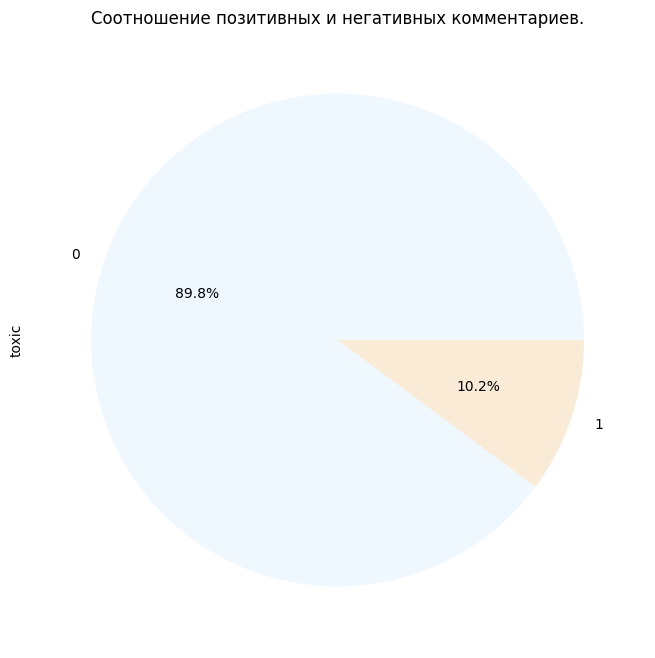

In [8]:
pie = df['toxic'].value_counts()
pie.plot(kind='pie', subplots=True, figsize=(10, 8), autopct='%1.1f%%', colors=mcolors.CSS4_COLORS, legend=None)
plt.title('Соотношение позитивных и негативных комментариев.')
plt.show()

Загрузили и изучили данные. Файл состоит из 159292 наблюдений и 3 признаков. Для модели BERT мы используем выборку поменьше, чтобы сильно не перегружать память и сократить время обучения. Наблюдается сильный дисбаланс классов. Позитивных комментариев 90%, при обучении воспользуемся параметром class_weight.
Так же был удалён неинформативный признак, который, судя по всему, дублировал индекс.

## Подготовка к обучению.

In [9]:
df_bert = df.sample(700)
df_bert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 12003 to 146291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    700 non-null    object
 1   toxic   700 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 16.4+ KB


In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)


padded = np.array([i + [0]*(max_len  - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [11]:
batch_size = 100
embeddings = []

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
x = np.concatenate(embeddings)
y = df_bert['toxic']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=STATE)

print('Размер обущающей выборки:')
print(x_train.shape)
print(y_train.shape)
print('=' * 100)
print('Размер тестовой выборки:')
print(x_test.shape)
print(y_test.shape)

Размер обущающей выборки:
(490, 768)
(490,)
Размер тестовой выборки:
(210, 768)
(210,)


In [13]:
models_f1 = pd.DataFrame(columns = ['Модель', 'F1', 'Время обучения'])

Отобрали 700 случайных наблюдений. Выполнили токенизацию и эмбендинг признаков. Отделили целевой признак и разбили данные на тренировочную и тестовую выборки.

## Обучение моделей.

In [14]:
model_lr = LogisticRegression(random_state=STATE,
                              class_weight='balanced',
                              solver='liblinear')

start_time = time.time()
params = {'max_iter': range (100, 500),
          'C': range(5, 15)}

randomized_lr = RandomizedSearchCV(model_lr, n_iter=10,
                                       param_distributions= params,
                                       scoring='f1', n_jobs= -2,
                                       cv=5, random_state=STATE)

randomized_lr.fit(x_train, y_train)
time_lr = time.time() - start_time

best_f1_lr = randomized_lr.best_score_

print('Лучшие параметры LogisticRegression:', randomized_lr.best_params_)
print('F1:{:.3f}'.format(best_f1_lr))

models_f1 = models_f1.append({'Модель':'LogisticRegression',
                                  'F1':round(best_f1_lr, 3),
                                  'Время обучения':time_lr}, ignore_index=True)

Лучшие параметры LogisticRegression: {'max_iter': 474, 'C': 12}
F1:0.953


In [15]:
model_rfc = RandomForestClassifier(random_state=STATE, class_weight='balanced')

start_time = time.time()
params = {'n_estimators': range (100, 300),
          'max_depth': range (5, 8)}

randomized_rfc = RandomizedSearchCV(model_rfc, n_iter=10,
                                       param_distributions= params,
                                       scoring='f1', n_jobs= -2,
                                       cv=5, random_state=STATE)

randomized_rfc.fit(x_train, y_train)
time_rfc = time.time() - start_time

best_f1_rfc = randomized_rfc.best_score_

print('Лучшие параметры RandomForestClassifier:', randomized_rfc.best_params_)
print('F1:{:.3f}'.format(best_f1_rfc))

models_f1 = models_f1.append({'Модель':'RandomForestClassifier',
                                  'F1':round(best_f1_rfc, 3),
                                  'Время обучения':time_rfc}, ignore_index=True)

Лучшие параметры RandomForestClassifier: {'n_estimators': 210, 'max_depth': 5}
F1:0.983


In [16]:
model_lgbm = LGBMClassifier(random_state=STATE, class_weight='balanced')
start_time = time.time()
params = {'n_estimators': range (100, 300),
          'max_depth': range (5, 8),
          'learning_rate': [0.4]}

randomized_lgbm = RandomizedSearchCV(model_lgbm, n_iter=10,
                                       param_distributions= params,
                                       scoring='f1', n_jobs= -2,
                                       cv=5, random_state=STATE, verbose=1)

randomized_lgbm.fit(x_train, y_train)
time_lgbm = time.time() - start_time

best_f1_lgbm = randomized_lgbm.best_score_

print('Лучшие параметры LGBMClassifier:', randomized_lgbm.best_params_)
print('F1:{:.3f}'.format(best_f1_lgbm))

models_f1 = models_f1.append({'Модель':'LGBMClassifier',
                                  'F1':round(best_f1_lgbm, 3),
                                  'Время обучения':time_lgbm}, ignore_index=True)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training

In [17]:
models_f1

,Модель,F1,Время обучения
0,LogisticRegression,0.953,5.092928
1,RandomForestClassifier,0.983,36.527957
2,LGBMClassifier,0.964,43.731100


Все три наших модели практически одинаково хорошо себя показали по метрике F1. Тестирование будем проводить на модели логистической регресси, т.к. по времени обучения она однозначно лучше.

## Проверка моделей на тестовой выборке.

In [18]:
predict_test_lr = randomized_lr.predict(x_test)
f1_lr_test = f1_score(y_test, predict_test_lr)

print('Лучшая F1 LogisticRegression на тестовой выборке: {:.3f}'.format(f1_lr_test))

Лучшая F1 LogisticRegression на тестовой выборке: 0.941


Не удалось получить заданную F1 моделями с BERT. Максимальную метрику, которую нам удалось вывести F1=0,71 на LogisticTegression с размером выборки в 2000 строк, однако, мы сократили выборку до 700 строк для более быстрого процесса эмбендинга. Эмбендинг на 2000 строк занял больше одного часа. Возможно, будь у нас более мощное железо, то мы могли использовать большее количество строк, тем самым улучшив результат F1 до требуемой величины на тестовой выборке. Принимаем решение найти лучшее F1 без помощи BERT.

# TF-IDF.

## Подготовка признаков.

In [19]:
x_tf = df.drop(columns=["toxic"])
y_tf = df["toxic"]

In [20]:
x_train_tf, x_test_tf, corpus_y_train, corpus_y_test = train_test_split(
    x_tf, y_tf, test_size=0.4, random_state=STATE)

print('Размер обущающей выборки:')
print(x_train_tf.shape)
print(corpus_y_train.shape)
print('=' * 100)
print('Размер тестовой выборки:')
print(x_test_tf.shape)
print(corpus_y_test.shape)

Размер обущающей выборки:
(95575, 1)
(95575,)
Размер тестовой выборки:
(63717, 1)
(63717,)


In [21]:
def lemmatize(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [22]:
def clear_text(text):
    text = re.sub(r'[^A-Za-z\' ]', ' ', text)
    text = " ".join(text.split())
    return text

In [23]:
train_lem = x_train_tf['text'].apply(lambda x: lemmatize(clear_text(x))).values
test_lem = x_test_tf['text'].apply(lambda x: lemmatize(clear_text(x))).values

In [24]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))
tf_idf_train = count_tf_idf.fit_transform(train_lem)
tf_idf_test = count_tf_idf.transform(test_lem)

print('Матрица cо значениями TF-IDF на тренировочной выборке:')
print(tf_idf_train.shape)
print('=' * 100)
print('Матрица cо значениями TF-IDF на тестовой выборке:')
print(tf_idf_test.shape)

Матрица cо значениями TF-IDF на тренировочной выборке:
(95575, 115266)
Матрица cо значениями TF-IDF на тестовой выборке:
(63717, 115266)


In [25]:
models_f1_tf = pd.DataFrame(columns = ['Модель', 'F1', 'Время обучения'])

В этот раз использовали все данные. Отделили целевой признак и разделили данные на тренировочную и тестовую выборки. Для борьбы с дисбалансом классов использовали параметр class_weight. Выполнили лемматизацию, очистку текста от лишних символов и создали матрицу cо значениями TF-IDF.

## Обучение моделей.

In [26]:
model_lr_tf = LogisticRegression(random_state=STATE,
                                 class_weight='balanced',
                                 solver='liblinear')

start_time = time.time()
params = {'max_iter': range (100, 500),
          'C': range(5, 15)}

randomized_lr_tf = RandomizedSearchCV(model_lr_tf, n_iter=5,
                                       param_distributions= params,
                                       scoring='f1', n_jobs= -2,
                                       cv=3, random_state=STATE)

randomized_lr_tf.fit(tf_idf_train, corpus_y_train)
time_lr_tf = time.time() - start_time

best_f1_lr_tf = randomized_lr_tf.best_score_

print('Лучшие параметры LogisticRegression:', randomized_lr_tf.best_params_)
print('F1:{:.3f}'.format(best_f1_lr_tf))

models_f1_tf = models_f1_tf.append({'Модель':'LogisticRegression',
                                  'F1':round(best_f1_lr_tf, 3),
                                  'Время обучения':time_lr_tf}, ignore_index=True)

Лучшие параметры LogisticRegression: {'max_iter': 474, 'C': 12}
F1:0.769


In [27]:
model_rfc_tf = RandomForestClassifier(random_state=STATE,
                                      class_weight='balanced')

start_time = time.time()
params = {'n_estimators': range (150, 300),
          'max_depth': range (5, 7)}

randomized_rfc_tf = RandomizedSearchCV(model_rfc_tf, n_iter=5,
                                       param_distributions= params,
                                       scoring='f1', n_jobs= -2,
                                       cv=3, random_state=STATE)

randomized_rfc_tf.fit(tf_idf_train, corpus_y_train)
time_rfc_tf = time.time() - start_time

best_f1_rfc_tf = randomized_rfc_tf.best_score_

print('Лучшие параметры RandomForestClassifier:', randomized_rfc_tf.best_params_)
print('F1:{:.3f}'.format(best_f1_rfc_tf))

models_f1_tf = models_f1_tf.append({'Модель':'RandomForestClassifier',
                                  'F1':round(best_f1_rfc_tf, 3),
                                  'Время обучения':time_rfc_tf}, ignore_index=True)

Лучшие параметры RandomForestClassifier: {'n_estimators': 266, 'max_depth': 6}
F1:0.324


In [28]:
model_lgbm_tf = LGBMClassifier(random_state=STATE,
                               class_weight='balanced')

start_time = time.time()
params = {'n_estimators': range (150, 300),
          'max_depth': range (5, 8),
          'learning_rate': [0.4]}

randomized_lgbm_tf = RandomizedSearchCV(model_lgbm_tf, n_iter=5,
                                       param_distributions= params,
                                       scoring='f1', n_jobs= -2,
                                       cv=3, random_state=STATE, verbose=1)

randomized_lgbm_tf.fit(tf_idf_train, corpus_y_train)
time_lgbm_tf = time.time() - start_time

best_f1_lgbm_tf = randomized_lgbm_tf.best_score_

print('Лучшие параметры LGBMClassifier:', randomized_lgbm_tf.best_params_)
print('F1:{:.3f}'.format(best_f1_lgbm_tf))

models_f1_tf = models_f1_tf.append({'Модель':'LGBMClassifier',
                                  'F1':round(best_f1_lgbm_tf, 3),
                                  'Время обучения':time_lgbm_tf}, ignore_index=True)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6524, number of negative: 57192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.287688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348423
[LightGBM] [Info] Number of data points in the train set: 63716, number of used features: 6560
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [29]:
models_f1_tf

,Модель,F1,Время обучения
0,LogisticRegression,0.769,78.396181
1,RandomForestClassifier,0.324,379.746726
2,LGBMClassifier,0.756,698.111245


За лучшую модель принимаем логистическу регрессию. В этот раз для предсказания воспользуемся не predict(x), а на основе вероятностей классов расчитанных функцией predict_proba(x) и сами разделим значения целового признака на классы выбранным порогом.

## Проверка лучшей модели на тестовой выборке.

In [30]:
probabilities_test_tf = randomized_lr_tf.predict_proba(tf_idf_test)

thresholds, precision, recall, f1 = [], [], [], []
for threshold in np.arange(0.0, 1, 0.01):
    predicted_test = probabilities_test_tf[:, 1] > threshold
    precision.append(
        precision_score(corpus_y_test, predicted_test, zero_division=False)
    )
    recall.append(recall_score(corpus_y_test, predicted_test))
    f1.append(f1_score(corpus_y_test, predicted_test))
    thresholds.append(threshold)

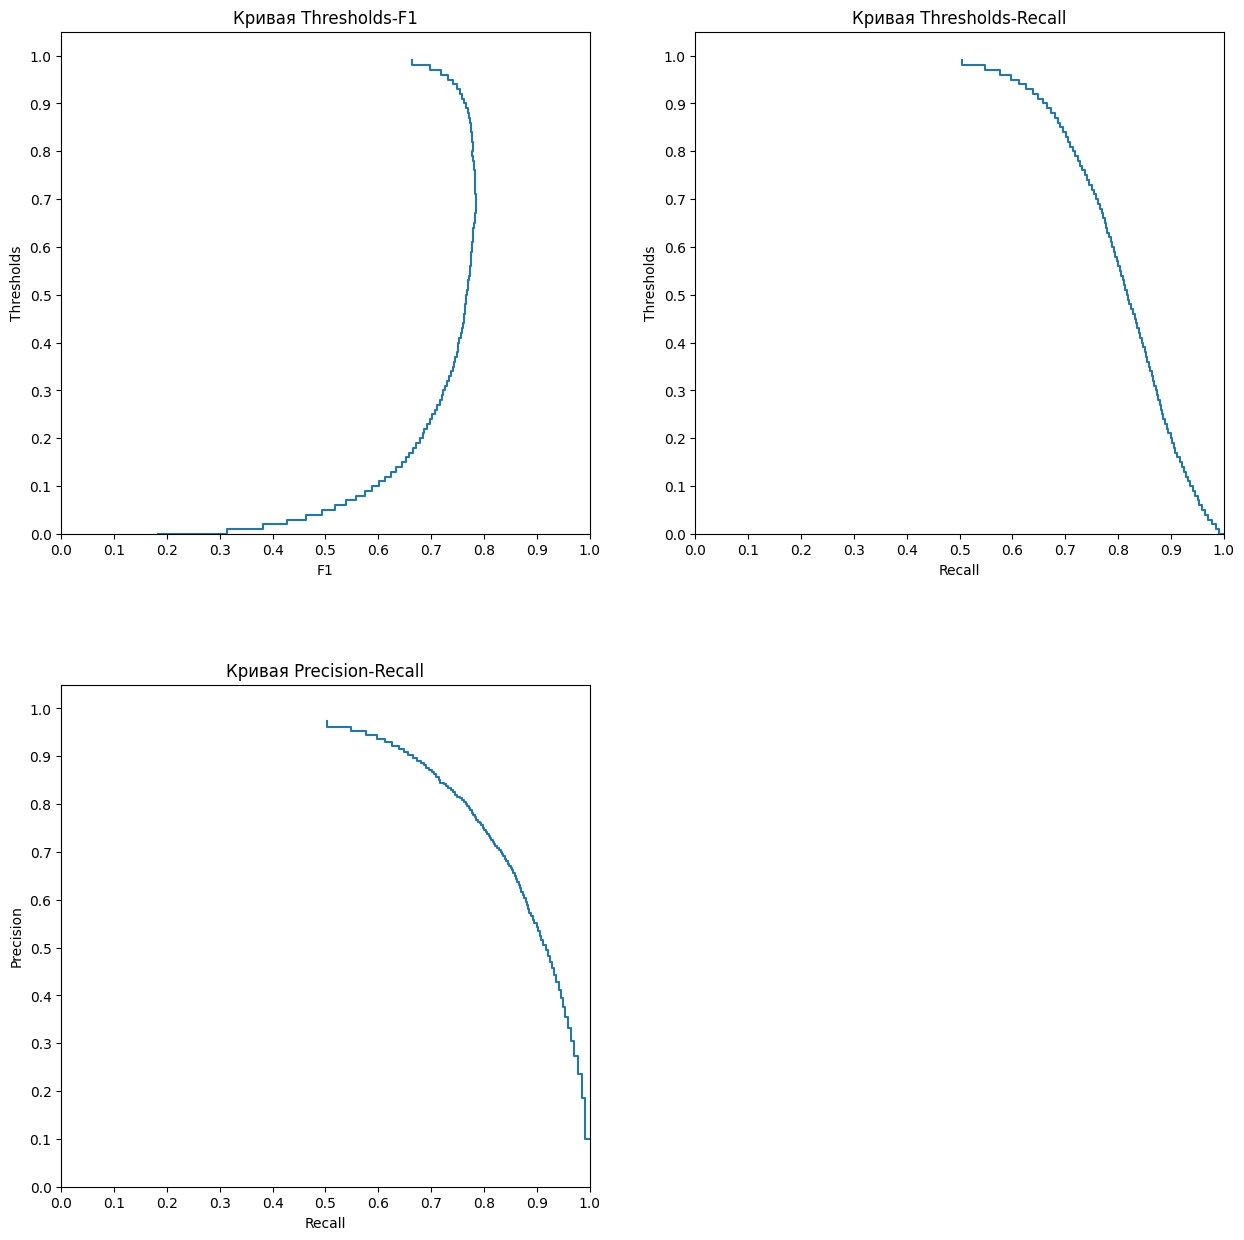

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)

plt.sca(ax1)
plt.step(f1, thresholds, where="post")
plt.xlabel("F1")
plt.ylabel("Thresholds")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Кривая Thresholds-F1")
plt.gca().xaxis.set(ticks=np.arange(0, 1.1, 0.1))
plt.gca().yaxis.set(ticks=np.arange(0, 1.1, 0.1))

plt.sca(ax2)
plt.step(recall, thresholds, where="post")
plt.xlabel("Recall")
plt.ylabel("Thresholds")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Кривая Thresholds-Recall")
plt.gca().xaxis.set(ticks=np.arange(0, 1.1, 0.1))
plt.gca().yaxis.set(ticks=np.arange(0, 1.1, 0.1))

plt.sca(ax3)
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Кривая Precision-Recall")
plt.gca().xaxis.set(ticks=np.arange(0, 1.1, 0.1))
plt.gca().yaxis.set(ticks=np.arange(0, 1.1, 0.1))

plt.sca(ax4)
plt.axis("off")
pass

In [32]:
prob_threshold_tf = 0.7

predictions_test_tf  = probabilities_test_tf[:, 1] > prob_threshold_tf
f1_lr_test_tf = f1_score(corpus_y_test, predictions_test_tf)

print('Лучшая F1 LogisticRegression на тестовой выборке: {:.3f}'.format(f1_lr_test_tf))

Лучшая F1 LogisticRegression на тестовой выборке: 0.785


# Общий вывод.

В этой работе нам нужно было создать инструмент для интернет-магазина, который будет искать токсичные комментарии. В нашем распоряжении был набор данных с разметкой о токсичности правок. Данные были загружены, изучены и обработаны для дальнейшего обучения. Был выявлен сильный дисбаланс классов. Использованы инструменты для борьбы с ним.

В первой части работы мы с помощью BERT обучили три модели: LogisticRegression, RandomForestClassifier и LGBMClassifier. Все модели показали отличный результат по заданной метрике. Выбор пал на модель LogisticRegression. Не смотря на чуть худший результат в сравнении с другими моделями, эта модель оказалась самой быстрой в обучении (за 8 секунд). F1 большей, чем 0.75, нам достичь на удалось, максимальный результат был 0.7.

Во второй части работы мы уже без BERT обучили те же модели. Вновь была выбрана модель LogisticRegression. В этот раз превзойти заданную F1 нам удалось.  Модель логистической регрессии быстро обучается и идеально подходит для задач бинарной классификации.